<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [20]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [21]:
response = requests.get(url)
response

<Response [200]>

In [22]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients', 'patients_summary', 'discharges_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])

In [23]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [46]:
keys = ['contacts', 'querents', 'patients_summary', 'discharges_summary']

In [94]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,discharges_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...,...
2020-08-18 17:00:00+09:00,791,1973,207,0,2020-08-18 17:00:00+09:00
2020-08-19 17:00:00+09:00,783,1858,186,0,2020-08-19 17:00:00+09:00
2020-08-20 17:00:00+09:00,754,1782,339,0,2020-08-20 17:00:00+09:00
2020-08-21 17:00:00+09:00,0,0,258,0,2020-08-21 17:00:00+09:00


In [95]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum
2020-08-18 17:00:00+09:00,791,1973,207,0,2020-08-18 17:00:00+09:00,928.428571,6499.0,1931.000000,13517.0,261.428571,1830.0,13.428571,94.0
2020-08-19 17:00:00+09:00,783,1858,186,0,2020-08-19 17:00:00+09:00,930.857143,6516.0,1918.571429,13430.0,256.285714,1794.0,7.142857,50.0
2020-08-20 17:00:00+09:00,754,1782,339,0,2020-08-20 17:00:00+09:00,922.857143,6460.0,1881.714286,13172.0,275.285714,1927.0,4.714286,33.0
2020-08-21 17:00:00+09:00,0,0,258,0,2020-08-21 17:00:00+09:00,803.428571,5624.0,1557.000000,10899.0,256.571429,1796.0,2.000000,14.0
2020-08-22 17:00:00+09:00,0,0,256,0,2020-08-22 17:00:00+09:00,633.142857,4432.0,1364.000000,9548.0,238.142857,1667.0,0.000000,0.0


In [96]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum,week_num,week_day
2020-08-08 17:00:00+09:00,1370,1026,429,197,2020-08-08 17:00:00+09:00,1224.142857,8569.0,2262.571429,15838.0,339.000000,2373.0,157.857143,1105.0,'20w32,Sat
2020-08-09 17:00:00+09:00,1282,1295,331,127,2020-08-09 17:00:00+09:00,1217.571429,8523.0,2248.428571,15739.0,344.571429,2412.0,159.000000,1113.0,'20w32,Sun
2020-08-10 17:00:00+09:00,1269,1328,197,73,2020-08-10 17:00:00+09:00,1188.142857,8317.0,1991.285714,13939.0,335.857143,2351.0,154.428571,1081.0,'20w33,Mon
2020-08-11 17:00:00+09:00,1058,3145,188,46,2020-08-11 17:00:00+09:00,1174.000000,8218.0,1995.285714,13967.0,318.571429,2230.0,142.428571,997.0,'20w33,Tue
2020-08-12 17:00:00+09:00,766,1945,222,44,2020-08-12 17:00:00+09:00,1124.857143,7874.0,1926.142857,13483.0,312.714286,2189.0,127.285714,891.0,'20w33,Wed
2020-08-13 17:00:00+09:00,810,2040,206,17,2020-08-13 17:00:00+09:00,1093.285714,7653.0,1877.857143,13145.0,290.714286,2035.0,104.142857,729.0,'20w33,Thu
2020-08-14 17:00:00+09:00,836,2273,389,19,2020-08-14 17:00:00+09:00,1055.857143,7391.0,1864.571429,13052.0,280.285714,1962.0,74.714286,523.0,'20w33,Fri
2020-08-15 17:00:00+09:00,1192,1351,385,14,2020-08-15 17:00:00+09:00,1030.428571,7213.0,1911.000000,13377.0,274.000000,1918.0,48.571429,340.0,'20w33,Sat
2020-08-16 17:00:00+09:00,1015,1360,260,0,2020-08-16 17:00:00+09:00,992.285714,6946.0,1920.285714,13442.0,263.857143,1847.0,30.428571,213.0,'20w33,Sun
2020-08-17 17:00:00+09:00,1089,2575,161,0,2020-08-17 17:00:00+09:00,966.571429,6766.0,2098.428571,14689.0,258.714286,1811.0,20.000000,140.0,'20w34,Mon


In [97]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [98]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2020-07-26 17:00:00+09:00,257.571429,1803
2020-08-02 17:00:00+09:00,320.142857,2241
2020-08-09 17:00:00+09:00,344.571429,2412
2020-08-16 17:00:00+09:00,263.857143,1847
2020-08-22 17:00:00+09:00,234.500000,1407


In [99]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,discharges_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,discharges_7d_mov_ave,discharges_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2020-08-08 17:00:00+09:00,1370,1026,429,197,2020-08-08 17:00:00+09:00,1224.142857,8569.0,2262.571429,15838.0,339.000000,2373.0,157.857143,1105.0,'20w32,Sat,NaN,NaN
2020-08-09 17:00:00+09:00,1282,1295,331,127,2020-08-09 17:00:00+09:00,1217.571429,8523.0,2248.428571,15739.0,344.571429,2412.0,159.000000,1113.0,'20w32,Sun,344.571429,2412.0
2020-08-10 17:00:00+09:00,1269,1328,197,73,2020-08-10 17:00:00+09:00,1188.142857,8317.0,1991.285714,13939.0,335.857143,2351.0,154.428571,1081.0,'20w33,Mon,NaN,NaN
2020-08-11 17:00:00+09:00,1058,3145,188,46,2020-08-11 17:00:00+09:00,1174.000000,8218.0,1995.285714,13967.0,318.571429,2230.0,142.428571,997.0,'20w33,Tue,NaN,NaN
2020-08-12 17:00:00+09:00,766,1945,222,44,2020-08-12 17:00:00+09:00,1124.857143,7874.0,1926.142857,13483.0,312.714286,2189.0,127.285714,891.0,'20w33,Wed,NaN,NaN
2020-08-13 17:00:00+09:00,810,2040,206,17,2020-08-13 17:00:00+09:00,1093.285714,7653.0,1877.857143,13145.0,290.714286,2035.0,104.142857,729.0,'20w33,Thu,NaN,NaN
2020-08-14 17:00:00+09:00,836,2273,389,19,2020-08-14 17:00:00+09:00,1055.857143,7391.0,1864.571429,13052.0,280.285714,1962.0,74.714286,523.0,'20w33,Fri,NaN,NaN
2020-08-15 17:00:00+09:00,1192,1351,385,14,2020-08-15 17:00:00+09:00,1030.428571,7213.0,1911.000000,13377.0,274.000000,1918.0,48.571429,340.0,'20w33,Sat,NaN,NaN
2020-08-16 17:00:00+09:00,1015,1360,260,0,2020-08-16 17:00:00+09:00,992.285714,6946.0,1920.285714,13442.0,263.857143,1847.0,30.428571,213.0,'20w33,Sun,263.857143,1847.0
2020-08-17 17:00:00+09:00,1089,2575,161,0,2020-08-17 17:00:00+09:00,966.571429,6766.0,2098.428571,14689.0,258.714286,1811.0,20.000000,140.0,'20w34,Mon,NaN,NaN


### グラフ出力

In [100]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [101]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

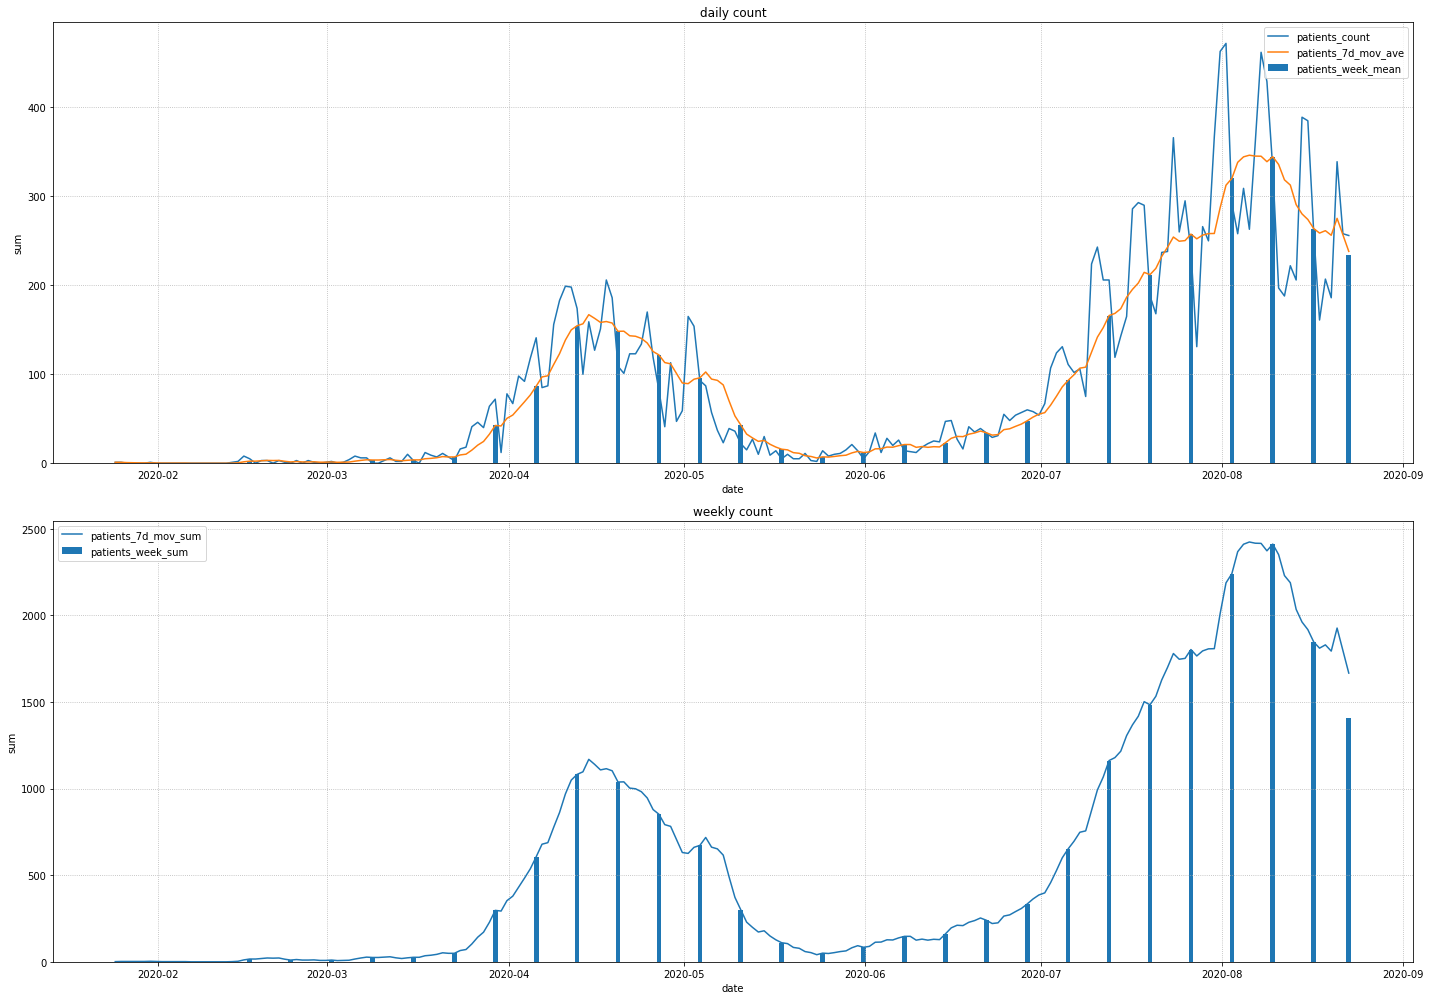

In [102]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [103]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [104]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [105]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [106]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [110]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
197,1.596874e+09,2020,8,8,0,0,1,0,0,0,0,197,0,123,1370,1224.142857,8569.0,1026,2262.571429,15838.0,429,339.000000,2373.0,197,157.857143,1105.0
198,1.596960e+09,2020,8,9,0,0,0,1,0,0,0,198,0,124,1282,1217.571429,8523.0,1295,2248.428571,15739.0,331,344.571429,2412.0,127,159.000000,1113.0
199,1.597046e+09,2020,8,10,0,1,0,0,0,0,0,199,0,125,1269,1188.142857,8317.0,1328,1991.285714,13939.0,197,335.857143,2351.0,73,154.428571,1081.0
200,1.597133e+09,2020,8,11,0,0,0,0,0,1,0,200,0,126,1058,1174.000000,8218.0,3145,1995.285714,13967.0,188,318.571429,2230.0,46,142.428571,997.0
201,1.597219e+09,2020,8,12,0,0,0,0,0,0,1,201,0,127,766,1124.857143,7874.0,1945,1926.142857,13483.0,222,312.714286,2189.0,44,127.285714,891.0
202,1.597306e+09,2020,8,13,0,0,0,0,1,0,0,202,0,128,810,1093.285714,7653.0,2040,1877.857143,13145.0,206,290.714286,2035.0,17,104.142857,729.0
203,1.597392e+09,2020,8,14,1,0,0,0,0,0,0,203,0,129,836,1055.857143,7391.0,2273,1864.571429,13052.0,389,280.285714,1962.0,19,74.714286,523.0
204,1.597478e+09,2020,8,15,0,0,1,0,0,0,0,204,0,130,1192,1030.428571,7213.0,1351,1911.000000,13377.0,385,274.000000,1918.0,14,48.571429,340.0
205,1.597565e+09,2020,8,16,0,0,0,1,0,0,0,205,0,131,1015,992.285714,6946.0,1360,1920.285714,13442.0,260,263.857143,1847.0,0,30.428571,213.0
206,1.597651e+09,2020,8,17,0,1,0,0,0,0,0,206,0,132,1089,966.571429,6766.0,2575,2098.428571,14689.0,161,258.714286,1811.0,0,20.000000,140.0


In [111]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              212 non-null    float64
 1   year                   212 non-null    int64  
 2   month                  212 non-null    int64  
 3   day                    212 non-null    int64  
 4   Fri                    212 non-null    uint8  
 5   Mon                    212 non-null    uint8  
 6   Sat                    212 non-null    uint8  
 7   Sun                    212 non-null    uint8  
 8   Thu                    212 non-null    uint8  
 9   Tue                    212 non-null    uint8  
 10  Wed                    212 non-null    uint8  
 11  passed                 212 non-null    int64  
 12  emergency              212 non-null    int64  
 13  em_passed              212 non-null    int64  
 14  contacts_count         212 non-null    int64  
 15  contac

In [112]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
count,2.120000e+02,212.0,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,1.588968e+09,2020.0,4.750000,15.688679,0.146226,0.141509,0.146226,0.141509,0.141509,0.141509,0.141509,105.500000,0.231132,44.589623,865.867925,860.455413,6023.169811,1239.551887,1226.598383,8586.188679,90.193396,86.622844,606.283019,58.283019,58.294003,407.981132
std,5.300061e+06,0.0,2.044238,8.821412,0.354169,0.349371,0.354169,0.349371,0.349371,0.349371,0.349371,61.343296,0.422554,45.924897,543.342928,527.882765,3695.208847,848.717567,642.760635,4499.324443,111.507743,102.827231,719.855281,67.428495,61.739482,432.248623
min,1.579853e+09,2020.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.584410e+09,2020.0,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.750000,0.000000,0.000000,485.500000,486.214286,3403.500000,521.000000,912.321429,6386.250000,5.000000,4.785714,33.500000,3.000000,3.857143,27.000000
50%,1.588968e+09,2020.0,5.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.500000,0.000000,31.500000,725.500000,690.928571,4836.500000,1220.000000,1166.000000,8162.000000,38.000000,33.357143,233.500000,27.000000,30.000000,210.000000
75%,1.593526e+09,2020.0,6.250000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,158.250000,0.000000,84.250000,1240.500000,1226.357143,8584.500000,1777.000000,1607.071429,11249.500000,151.750000,144.535714,1011.750000,101.500000,106.642857,746.500000
max,1.598083e+09,2020.0,8.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,211.000000,1.000000,137.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,472.000000,346.285714,2424.000000,255.000000,200.000000,1400.000000


In [113]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum,discharges_count,discharges_7d_mov_ave,discharges_7d_mov_sum
timestamp,1.000000e+00,NaN,0.989910,-0.014889,-0.003381,-0.006634,0.003381,-0.013268,0.013268,5.363301e-18,0.006634,1.000000e+00,-0.067193,0.956815,0.397408,0.471582,0.471587,0.497784,0.716579,0.716579,0.689229,0.728583,0.728700,0.438717,0.525225,0.525441
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,9.899104e-01,NaN,1.000000,-0.156243,-0.008182,-0.003318,0.004909,-0.009954,0.009954,-3.317943e-03,0.009954,9.899104e-01,-0.064468,0.945089,0.398968,0.468682,0.468687,0.500893,0.720854,0.720854,0.689361,0.727029,0.727160,0.452170,0.525560,0.525800
day,-1.488885e-02,NaN,-0.156243,1.000000,0.034360,-0.022544,-0.012665,-0.021007,0.022051,2.358886e-02,-0.024082,-1.488885e-02,0.000324,-0.008073,-0.032366,-0.006863,-0.006871,-0.055102,-0.079862,-0.079862,-0.066505,-0.059828,-0.059938,-0.127813,-0.043804,-0.043990
Fri,-3.381202e-03,NaN,-0.008182,0.034360,1.000000,-0.168022,-0.171271,-0.168022,-0.168022,-1.680221e-01,-0.168022,-3.381202e-03,-0.005228,0.002250,-0.026867,-0.011425,-0.011423,0.038138,-0.010073,-0.010073,0.095885,0.001373,0.001305,0.079030,-0.008911,-0.009022
Mon,-6.634138e-03,NaN,-0.003318,-0.022544,-0.168022,1.000000,-0.168022,-0.164835,-0.164835,-1.648352e-01,-0.164835,-6.634138e-03,0.002120,-0.007883,0.049058,0.001984,0.001986,0.271516,-0.001247,-0.001247,-0.113236,-0.005923,-0.005908,-0.107529,0.003634,0.003658
Sat,3.381202e-03,NaN,0.004909,-0.012665,-0.171271,-0.168022,1.000000,-0.168022,-0.168022,-1.680221e-01,-0.168022,3.381202e-03,-0.005228,0.008078,0.009632,-0.011425,-0.011423,-0.349047,-0.010073,-0.010073,0.090365,0.006113,0.006064,0.077839,-0.008942,-0.009022
Sun,-1.326828e-02,NaN,-0.009954,-0.021007,-0.168022,-0.164835,-0.168022,1.000000,-0.164835,-1.648352e-01,-0.164835,-1.326828e-02,0.002120,-0.013496,-0.008140,-0.002014,-0.002012,-0.300384,-0.009011,-0.009011,-0.023577,-0.008936,-0.008942,-0.005933,0.003670,0.003658
Thu,1.326828e-02,NaN,0.009954,0.022051,-0.168022,-0.164835,-0.168022,-0.164835,1.000000,-1.648352e-01,-0.164835,1.326828e-02,0.002120,0.009544,0.006590,0.010530,0.010532,0.103227,0.015676,0.015676,0.055742,0.007844,0.007887,0.054824,0.003586,0.003658
Tue,5.363301e-18,NaN,-0.003318,0.023589,-0.168022,-0.164835,-0.168022,-0.164835,-0.164835,1.000000e+00,-0.164835,2.356919e-18,0.002120,-0.002271,-0.022720,0.004888,0.004890,0.155717,0.004701,0.004701,-0.048151,-0.002035,-0.002007,-0.042347,0.003612,0.003658


In [114]:
!python -V

Python 3.6.9
